In [21]:
import networkx as nx
import matplotlib.pyplot as plt
import warnings
import qiskit
import random
import numpy as np
warnings.simplefilter("ignore")


#### Utils functions

In [2]:
def test_graphbuild(graph_data, graph_number=1):
    """
    Tests graph building from a graph_specs database by:
    1. Building the graph
    2. Printing nodes, neighbors and weight values
    3. Plotting the built graph
    if `graph_number` is None then all graphs in graph_data are built and tested
    Parameters:  
        graph_data (list(tuples)): graph_specs database
        graph_number (int): graph number to build and test.  
    Returns:
        None
    """
    plt.figure(figsize=(2,2))
    for g_num, g_data in graph_data.items():
        plt.clf()
        cond = True
        if graph_number is not None:
            cond = g_num == str(graph_number)
        if g_data and cond:
            G = nx.DiGraph()
            G.add_weighted_edges_from(g_data)
            # print nodes and neighbors
            for node, ngbrs in G.adjacency():
                for ngbr, edge_attr in ngbrs.items():
                    print("Node:{}, Neighbor:{}, Weight:{}".format(node, ngbr, edge_attr["weight"]))
            # plot
            options = {
            'with_labels': True,
            'node_color': 'red',
            'node_size': 175,
            'width': 2,
            'font_weight':'bold',
            'font_color': 'white',
            }
            nx.draw_circular(G, **options)
            plt.title('No. %s' % g_num, loc='right')
            plt.show()

def build_graph_database(graph_data):
    """
    Build graph database (dictionary of networkx.DiGraph) from graph_data dictionary.
    """
    graph_db= dict([('%d' %d, {'G':None, 'V':None, 'LUclass':None, '2Color':None}) 
                          for d in range(1,len(graph_data.keys()) + 1)])
    for (g_num, g_entry), (_, g_data) in zip(graph_db.items(), graph_data.items()):
        if g_data:
            g_data = offset(g_data)
            G = nx.DiGraph()
            G.add_weighted_edges_from(g_data)
            g_entry['G'] = G
            g_entry['V'] = len(G.nodes)
    return graph_db
        
    
def _build_from_graph(graph, gate_type="controlled_phase_gate", verbose=True, state_vec=True):
    """
    Builds a circuit from a graph by applying a 2-qubit gate between a node (qubit) and its neighbors (qubits)
    Parameters:
        graph (networks.DiGraph): graph object
        gate_type (string): type of gate to apply. if gate_type="controlled_phase_gate" then applies H_a-CNOT_{a,b}-H_a where a,b are qubits
    """
    
    n_qubits = len(graph.nodes)
    q_reg = qiskit.QuantumRegister(n_qubits)
    c_reg = qiskit.ClassicalRegister(n_qubits)
    circ = qiskit.QuantumCircuit(q_reg, c_reg)
    for node, ngbrs in graph.adjacency():
        for ngbr, edge_attr in ngbrs.items():
            if gate_type == "controlled_phase_gate":
                circ.h(node)
                circ.cx(node, ngbr)
                circ.h(node)
                print("Adding {} between Node:{} and Neighbor:{}".format(gate_type, node, ngbr)) 
            else:
                pass
    if state_vec:
        return circ
    circ.measure(q_reg, c_reg)
    return circ

def offset(l):
    l = [(edge[0]-1, edge[1]-1, edge[-1]) for edge in l]
    return l

### Populate a Dictionary of graph specs  
The keys correspond to the graph numbers in Table V in arXiv:060296 (Hein et al.)

In [3]:
# Dictionary of graph specs, the keys correspond to the graph numbers in Table V in arXiv:060296 (Hein et al.)
graph_data = dict([('%d' %d, None) for d in range(1,46)])

graph_data['1'] =  [(1, 2, 1.0)]
graph_data['2'] =  [(1, 2, 1.0), (1, 3, 1.0)]
graph_data['3'] =  [(1, 2, 1.0), (1, 3, 1.0), (1, 4, 1.0)]
graph_data['4'] =  [(1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0)]
graph_data['5'] =  [(1, 2, 1.0), (1, 3, 1.0), (1, 4, 1.0), (1, 5, 1.0)]
graph_data['6'] =  [(1, 2, 1.0), (2, 3, 1.0), (2, 5, 1.0), (3, 4, 1.0)]
graph_data['7'] =  [(1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0), (4, 5, 1.0)]
graph_data['8'] =  [(1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0), (4, 5, 1.0), (5, 1, 1.0)]
graph_data['9'] =  [(1, 2, 1.0), (1, 3, 1.0), (1, 4, 1.0), (1, 4, 1.0), (1, 6, 1.0)]
graph_data['10'] = [(1, 6, 1.0), (2, 6, 1.0), (3, 6, 1.0), (4, 5, 1.0), (5, 6, 1.0)]
graph_data['11'] = [(1, 6, 1.0), (2, 6, 1.0), (3, 5, 1.0), (4, 5, 1.0), (5, 6, 1.0)]
graph_data['12'] = [(1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0), (4, 5, 1.0), (6, 2, 1.0)]
graph_data['13'] = [(1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0), (4, 5, 1.0), (3, 6, 1.0)]
graph_data['14'] = [(1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0), (4, 5, 1.0), (5, 6, 1.0)]
graph_data['15'] = [(1, 6, 1.0), (2, 4, 1.0), (3, 4, 1.0), (3, 6, 1.0), (4, 5, 1.0), (5, 6, 1.0)]
graph_data['16'] = [(1, 2, 1.0), (2, 3, 1.0), (2, 4, 1.0), (3, 4, 1.0), (2, 6, 1.0), (4, 5, 1.0)]
graph_data['17'] = [(1, 2, 1.0), (1, 5, 1.0), (1, 6, 1.0), (2, 3, 1.0), (3, 4, 1.0), (4, 5, 1.0)]
graph_data['18'] = [(1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0), (4, 5, 1.0), (5, 6, 1.0), (6, 1, 1.0)]
graph_data['19'] = [(1, 2, 1.0), (1, 3, 1.0), (2, 3, 1.0), (2, 5, 1.0), (3, 4, 1.0), (4, 5, 1.0), (4, 6, 1.0), (5, 6, 1.0), (6, 1, 1.0)]
graph_data['20'] = [(1, 2, 1.0), (1, 3, 1.0), (1, 4, 1.0), (1, 5, 1.0), (1, 6, 1.0), (1, 7, 1.0)]
graph_data['21'] = [(1, 7, 1.0), (7, 2, 1.0), (7, 3, 1.0), (7, 4, 1.0), (5, 6, 1.0), (6, 7, 1.0)]
graph_data['22'] = [(1, 7, 1.0), (7, 2, 1.0), (7, 3, 1.0), (7, 6, 1.0), (6, 4, 1.0), (6, 5, 1.0)]
graph_data['23'] = [(1, 7, 1.0), (7, 2, 1.0), (7, 3, 1.0), (7, 6, 1.0), (6, 5, 1.0), (5, 4, 1.0)]
graph_data['24'] = [(1, 7, 1.0), (7, 6, 1.0), (7, 2, 1.0), (6, 5, 1.0), (5, 3, 1.0), (5, 4, 1.0)]
graph_data['25'] = [(1, 2, 1.0), (1, 7, 1.0), (7, 3, 1.0), (7, 4, 1.0), (7, 6, 1.0), (6, 5, 1.0)]
graph_data['26'] = [(1, 7, 1.0), (7, 2, 1.0), (7, 6, 1.0), (6, 3, 1.0), (6, 5, 1.0), (5, 4, 1.0)]
graph_data['27'] = [(1, 2, 1.0), (2, 7, 1.0), (2, 3, 1.0), (3, 4, 1.0), (4, 5, 1.0), (5, 6, 1.0)]
graph_data['28'] = [(1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0), (3, 5, 1.0), (5, 6, 1.0), (6, 7, 1.0)]
graph_data['29'] = [(1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0), (4, 5, 1.0), (3, 6, 1.0), (6, 7, 1.0)]
graph_data['30'] = [(1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0), (4, 5, 1.0), (5, 6, 1.0), (6, 7, 1.0)]
graph_data['31'] = [(1, 3, 1.0), (2, 3, 1.0), (3, 4, 1.0), (3, 6, 1.0), (4, 5, 1.0), (5, 6, 1.0), (6, 3, 1.0), (5, 7 , 1.0)]
graph_data['32'] = [(1, 7, 1.0), (2, 7, 1.0), (3, 6, 1.0), (4, 5, 1.0), (5, 6, 1.0), (6, 7, 1.0)]
graph_data['33'] = [(1, 3, 1.0), (2, 3, 1.0), (3, 4, 1.0), (4, 5, 1.0), (5, 6, 1.0), (6, 7, 1.0), (7, 3, 1.0)]          
graph_data['34'] = [(1, 4, 1.0), (2, 3, 1.0), (3, 4, 1.0), (3, 6, 1.0), (4, 5, 1.0), (5, 6, 1.0), (6, 7, 1.0)]
graph_data['35'] = [(1, 6, 1.0), (2, 3, 1.0), (3, 4, 1.0), (4, 5, 1.0), (5, 6, 1.0), (6, 7, 1.0), (7, 3, 1.0)]
graph_data['36'] = [(1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0), (3, 5, 1.0), (4, 5, 1.0), (4, 7, 1.0), (5, 6, 1.0)]
graph_data['37'] = [(1, 7, 1.0), (7, 6, 1.0), (6, 5, 1.0), (5, 4, 1.0), (4, 3, 1.0), (3, 2, 1.0), (3, 7, 1.0)]
graph_data['38'] = [(1, 6, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0), (4, 5, 1.0), (5, 6, 1.0), (6, 7, 1.0)]
graph_data['39'] = [(1, 5, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0), (4, 5, 1.0), (5, 6, 1.0), (6, 7, 1.0)]
graph_data['40'] = [(1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0), (4, 5, 1.0), (5, 6, 1.0), (6, 7, 1.0), (7, 1, 1.0)]
graph_data['41'] = [(1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0), (4, 5, 1.0), (5, 6, 1.0), (5, 1, 1.0), (6, 1, 1.0), (6, 7, 1.0)]
graph_data['42'] = [(1, 3, 1.0), (1, 7, 1.0), (2, 3, 1.0), (2, 6, 1.0), (3, 4, 1.0), (4, 5, 1.0), (5, 6, 1.0), (6, 7, 1.0)]
graph_data['43'] = [(1, 2, 1.0), (1, 4, 1.0), (2, 3, 1.0), (3, 4, 1.0), (4, 5, 1.0), (5, 6, 1.0), (6, 3, 1.0), (7, 1, 1.0)]
graph_data['44'] = [(1, 4, 1.0), (1, 7, 1.0), (2, 3, 1.0), (2, 7, 1.0), (3, 4, 1.0), (3, 5, 1.0), (4, 5, 1.0), (5, 6, 1.0), (6, 7, 1.0)]
graph_data['45'] = [(1, 2, 1.0), (2, 3, 1.0), (2, 5, 1.0), (2, 7, 1.0), (3, 4, 1.0), (3, 7, 1.0), (4, 5, 1.0), (5, 6, 1.0), (4, 6, 1.0), (6, 7, 1.0)]                    
                    
                    
                    
                    

Node:1, Neighbor:2, Weight:1.0
Node:2, Neighbor:3, Weight:1.0
Node:2, Neighbor:5, Weight:1.0
Node:2, Neighbor:7, Weight:1.0
Node:3, Neighbor:4, Weight:1.0
Node:3, Neighbor:7, Weight:1.0
Node:5, Neighbor:6, Weight:1.0
Node:4, Neighbor:5, Weight:1.0
Node:4, Neighbor:6, Weight:1.0
Node:6, Neighbor:7, Weight:1.0


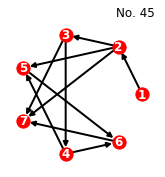

In [4]:
test_graphbuild(graph_data, graph_number=45)

Build and return a dictionary of graph objects

In [5]:
graph_db = build_graph_database(graph_data)

### Build circuit from a graph

In [6]:
graph = graph_db['22']['G']
circ = _build_from_graph(graph,state_vec=False)

Adding controlled_phase_gate between Node:0 and Neighbor:6
Adding controlled_phase_gate between Node:6 and Neighbor:1
Adding controlled_phase_gate between Node:6 and Neighbor:2
Adding controlled_phase_gate between Node:6 and Neighbor:5
Adding controlled_phase_gate between Node:5 and Neighbor:3
Adding controlled_phase_gate between Node:5 and Neighbor:4


In [7]:
circ.draw()

┌───┐     ┌───┐     ┌─┐                                              »
q0_0: |0>┤ H ├──■──┤ H ├─────┤M├──────────────────────────────────────────────»
         └───┘  │  └───┘┌───┐└╥┘     ┌─┐                                      »
q0_1: |0>───────┼───────┤ X ├─╫──────┤M├──────────────────────────────────────»
                │       └─┬─┘ ║      └╥┘     ┌───┐     ┌─┐                    »
q0_2: |0>───────┼─────────┼───╫───────╫──────┤ X ├─────┤M├────────────────────»
                │         │   ║       ║      └─┬─┘     └╥┘               ┌───┐»
q0_3: |0>───────┼─────────┼───╫───────╫────────┼────────╫────────────────┤ X ├»
                │         │   ║       ║        │        ║                └─┬─┘»
q0_4: |0>───────┼─────────┼───╫───────╫────────┼────────╫──────────────────┼──»
                │         │   ║       ║        │        ║      ┌───┐┌───┐  │  »
q0_5: |0>───────┼─────────┼───╫───────╫────────┼────────╫──────┤ X ├┤ H ├──■──»
              ┌─┴─┐┌───┐  │   ║ ┌───┐ ║ ┌───┐  │  ┌───┐ ║ ┌───┐└─┬─┘├───┤ ┌─┐ »
q0_6: |0>─────┤ X ├┤ H ├──■───╫─┤ H ├─╫─┤ H ├──■──┤ H ├─╫─┤ H ├──■──┤ H ├─┤M├─»
              └───┘└───┘      ║ └───┘ ║ └───┘     └───┘ ║ └───┘     └───┘ └╥┘ »
 c0_0: 0 ═════════════════════╩═══════╬═════════════════╬══════════════════╬══»
                                      ║                 ║                  ║  »
 c0_1: 0 ═════════════════════════════╩═════════════════╬══════════════════╬══»
                                                        ║                  ║  »
 c0_2: 0 ═══════════════════════════════════════════════╩══════════════════╬══»
                                                                           ║  »
 c0_3: 0 ══════════════════════════════════════════════════════════════════╬══»
                                                                           ║  »
 c0_4: 0 ══════════════════════════════════════════════════════════════════╬══»
                                                                           ║  »
 c0_5: 0 ══════════════════════════════════════════════════════════════════╬══»
                                                                           ║  »
 c0_6: 0 ══════════════════════════════════════════════════════════════════╩══»
                                                                              »
«                                   
«q0_0: ─────────────────────────────
«                                   
«q0_1: ─────────────────────────────
«                                   
«q0_2: ─────────────────────────────
«           ┌─┐                     
«q0_3: ─────┤M├─────────────────────
«           └╥┘     ┌───┐     ┌─┐   
«q0_4: ──────╫──────┤ X ├─────┤M├───
«      ┌───┐ ║ ┌───┐└─┬─┘┌───┐└╥┘┌─┐
«q0_5: ┤ H ├─╫─┤ H ├──■──┤ H ├─╫─┤M├
«      └───┘ ║ └───┘     └───┘ ║ └╥┘
«q0_6: ──────╫─────────────────╫──╫─
«            ║                 ║  ║ 
«c0_0: ══════╬═════════════════╬══╬═
«            ║                 ║  ║ 
«c0_1: ══════╬═════════════════╬══╬═
«            ║                 ║  ║ 
«c0_2: ══════╬═════════════════╬══╬═
«            ║                 ║  ║ 
«c0_3: ══════╩═════════════════╬══╬═
«                              ║  ║ 
«c0_4: ════════════════════════╩══╬═
«                                 ║ 
«c0_5: ═══════════════════════════╩═
«                                   
«c0_6: ═════════════════════════════
«

## Random Disjoint Union of Graphs

In [14]:
def random_combine_subgraphs(graph_db, target_qubits=4, smaller_subgraph=3):
    combs = list(set(partition(target_qubits, I=smaller_subgraph)))
    combs.pop() # remove
    sorted_dict = get_sorted_db(graph_db)
    graphs=[]
    for comb in combs:
        print('comb', comb)
        sub_graphs = []
        comb = list(comb)
        if len(comb) > 1:
            idx = 0
            while idx < len(comb):
                all_graphs = sorted_dict[comb[idx]]
                if len(all_graphs) < 1:
                    break
                graph_idx = random.randint(0, len(all_graphs)-1)
                sub_graphs.append(all_graphs[graph_idx])
                idx += 1
#             print('comb={}, subgraphs={}'.format(comb, sub_graphs))
        else:
            all_graphs = sorted_dict[comb[0]]
            if len(all_graphs) > 0:
                graph_idx = random.randint(0, len(all_graphs)-1)
                sub_graphs.append(all_graphs[graph_idx])
#                 print('comb={}, subgraphs={}'.format(comb, sub_graphs))
        graphs.append(sub_graphs)
    idx = random.randint(0, len(graphs)-1)
    sub_graphs = graphs[idx]
    print("chosen comb {}".format(combs[idx]))
    union_graph = nx.DiGraph()
    for sub_g in sub_graphs:
        union_graph = nx.disjoint_union(union_graph, sub_g)
    return union_graph
        
def combine_subgraphs(graph_db, target_qubits=4, smallest_subgraph=2, largest_subgraph=None):
    combs = list(set(partition(target_qubits, I=smallest_subgraph)))
    sorted_dict = get_sorted_db(graph_db)
    if largest_subgraph is None:
        for key, itm in sorted_dict.items():
            if len(itm) > 1:
                largest_subgraph = key
    for (itm, comb) in enumerate(combs):
        if any([itm > largest_subgraph for itm in comb]):
            combs.pop(itm)
    comb = list(combs[random.randint(0, len(combs) - 1)])
    sub_graphs = []
    if len(comb) > 1:
        idx = 0
        while idx < len(comb):
            all_subgraphs = sorted_dict[comb[idx]]
            graph_idx = random.randint(0, len(all_subgraphs) - 1)
            sub_graphs.append(all_subgraphs[graph_idx])
            idx += 1
    else:
        all_subgraphs = sorted_dict[comb[0]]
        graph_idx = random.randint(0, len(all_graphs) - 1)
        sub_graphs.append(all_graphs[graph_idx])
    
    union_graph = nx.DiGraph()
    for sub_g in sub_graphs:
        union_nodes = len(union_graph.nodes)
        if union_nodes > 1:
            first_node = random.randint(0, union_nodes - 1)
            offset = len(sub_g.nodes)
            second_node = random.randint(union_nodes, offset + union_nodes - 1)    
        union_graph = nx.disjoint_union(union_graph, sub_g)
        if union_nodes > 1:
            union_graph.add_weighted_edges_from([(first_node, second_node, 1.0)])
    return union_graph, sub_graphs

def get_sorted_db(gaph_db):
    sorted_dict = dict([(i, []) for i in range(1,len(graph_db.keys()))])
    for key, itm in graph_db.items():
        if itm["G"] is not None:
            sorted_key = len(itm["G"].nodes)
            sorted_dict[sorted_key].append(itm["G"])
    return sorted_dict
     
    
def partition(n, I=2):
    yield(n,)
    for i in range(I, n//2 + 1):
        for p in partition(n-i, i):
             yield (i,) + p

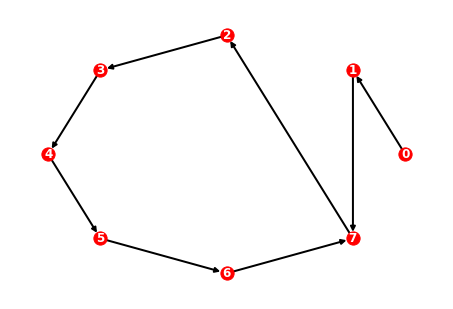

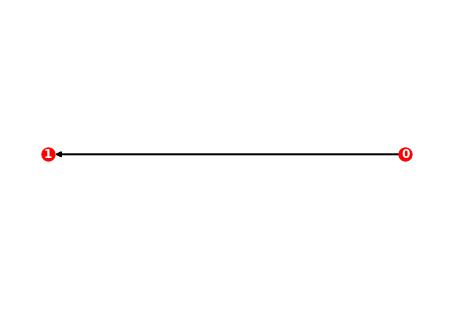

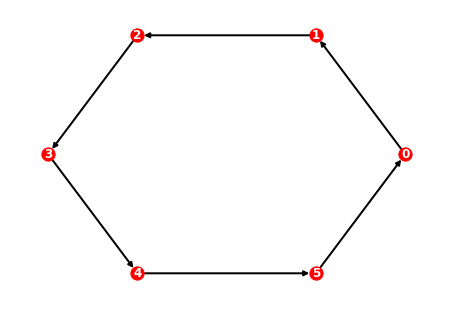

In [17]:
g, subgraphs  = combine_subgraphs(graph_db, target_qubits=8, smallest_subgraph=2)
options = {
            'with_labels': True,
            'node_color': 'red',
            'node_size': 175,
            'width': 2,
            'font_weight':'bold',
            'font_color': 'white',
            }
nx.draw_circular(g, **options)
for subg in subgraphs:
    plt.figure()
    nx.draw_circular(subg, **options)

Adding controlled_phase_gate between Node:0 and Neighbor:1
Adding controlled_phase_gate between Node:0 and Neighbor:2
Adding controlled_phase_gate between Node:1 and Neighbor:5
Adding controlled_phase_gate between Node:2 and Neighbor:3
Adding controlled_phase_gate between Node:2 and Neighbor:4
Adding controlled_phase_gate between Node:5 and Neighbor:6
Adding controlled_phase_gate between Node:5 and Neighbor:7


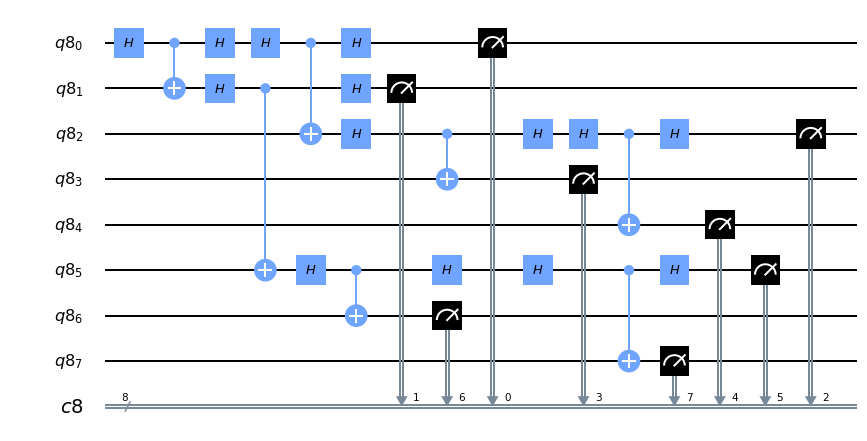

In [214]:
circ = _build_from_graph(g,state_vec=False)
circ.draw()

In [22]:
n_qubits=4
g, subgraphs= combine_subgraphs(graph_db, target_qubits=8, smallest_subgraph=2)
circ = _build_from_graph(g)
half = n_qubits//2 
ent_meas = []
for idx in range(100):
    sub_sys = np.random.choice(range(n_qubits), half, replace=False)
    val = qiskit.tools.qi.qi.entropy(qiskit.tools.qi.qi.partial_trace(
        qiskit.execute(circ, backend=qiskit.Aer.get_backend('statevector_simulator'), shots=1024).result().get_statevector(), sub_sys))
    print(sub_sys, np.round(val, 3))
    ent_meas.append(val)
    
print("mean={}, max={}, std={}".format(np.mean(ent_meas), np.max(ent_meas), np.std(ent_meas)))
# circ.draw()

Adding controlled_phase_gate between Node:0 and Neighbor:1
Adding controlled_phase_gate between Node:1 and Neighbor:2
Adding controlled_phase_gate between Node:2 and Neighbor:3
Adding controlled_phase_gate between Node:2 and Neighbor:4
Adding controlled_phase_gate between Node:4 and Neighbor:5
Adding controlled_phase_gate between Node:5 and Neighbor:6
Adding controlled_phase_gate between Node:6 and Neighbor:7
[2 3] 0.693
[3 0] 1.386
[0 2] 1.386
[1 2] 1.386
[1 3] 1.386
[2 3] 0.693
[2 3] 0.693
[1 0] 0.693
[2 3] 0.693
[0 2] 1.386
[0 3] 1.386
[3 0] 1.386
[3 1] 1.386
[1 0] 0.693
[3 0] 1.386
[2 3] 0.693
[0 1] 0.693
[3 2] 0.693
[0 3] 1.386
[3 0] 1.386
[0 3] 1.386
[2 0] 1.386
[1 2] 1.386
[1 3] 1.386
[2 0] 1.386
[0 2] 1.386
[1 3] 1.386
[1 0] 0.693
[1 0] 0.693
[1 0] 0.693
[2 3] 0.693
[3 2] 0.693
[1 2] 1.386
[2 1] 1.386
[0 1] 0.693
[3 0] 1.386
[1 0] 0.693
[3 0] 1.386
[0 1] 0.693
[3 1] 1.386
[2 0] 1.386
[3 2] 0.693
[1 0] 0.693
[0 2] 1.386
[0 3] 1.386
[0 3] 1.386
[2 1] 1.386
[1 0] 0.693
[0 1] 0.693